In [2]:
#import all the necessary libraries
import networkx as nx
import numpy as np
import pandas as pd
import networkx.algorithms.community as nx_comm
import math
import matplotlib.pyplot as plt
print("Libraries successfully imported")

Libraries successfully imported


In [3]:
#all the side functions
def generate_chrom(nodes_length,Adj):
    chrom = np.array([],dtype=int)
    for x in range(nodes_length):
        rand = np.random.randint(0,nodes_length)
        while Adj[x,rand] != 1:
            rand = np.random.randint(0,nodes_length)
        chrom = np.append(chrom,rand)
    return chrom

def merge_subsets(sub):
    arr =[]
    to_skip=[]
    for s in range(len(sub)):
        if sub[s] not in to_skip:
            new = sub[s]
            for x in sub:
                if sub[s] & x:
                    new = new | x
                    to_skip.append(x)
            arr.append(new)
    return arr

def find_subsets(chrom):
    sub = [{x,chrom[x]} for x in range(len(chrom))]
    result=sub
    i=0
    while i<len(result):
        candidate = merge_subsets(result)
        if candidate != result:
            result = candidate
        else:
            break
        result=candidate
        i+=1
    return result

def community_score(chrom,subsets,r,Adj):
    matrix = Adj.toarray()
    CS=0
    for s in subsets:
        submatrix = np.zeros((len(chrom),len(chrom)),dtype=int)
        for i in s:
            for j in s:
                submatrix[i][j]=matrix[i][j]
        M=0
        v=0
        PS=0
        for row in list(s):
            ki = np.sum(matrix[row])
            kiin = np.sum(submatrix[row])
            kiout = ki - kiin
            P= kiin/ki
            PS+=P
            row_mean = kiin/len(s)
            v+=np.sum(submatrix[row])
            M+=(row_mean**r)/len(s)
        CS+=M*v
    OS= 0.5*CS/len(subsets) + 0.5*(1/PS)*len(subsets)  #Overall score is calculated by maximizing CS and min PS
    return OS

def roulette_selection(df_elites):
    prob = np.random.random_sample()
    sum_cs=np.sum(df_elites["community_score"])
    x=0
    selected = 0
    for i in df_elites.index:
        x += df_elites["community_score"][i]
        X=x/sum_cs
        if prob < X:
            chosen=i
            break
    return chosen

def uniform_crossover_GE(parent_1,parent_2,crossover_rate):
    if np.random.random_sample() < crossover_rate:
        length = len(parent_1)
        mask = np.random.randint(2, size=length)
        child = np.zeros(length,dtype=int)
        for i in range(len(mask)):
            if mask[i] == 1:
                child[i]=parent_1[i]
            else:
                child[i]=parent_2[i]
        return child
    else:
        return np.array([])

def crossover_DE(parent,trial,crossover_rate):
    if np.random.random_sample() >= crossover_rate:
        length = len(parent['chrom'])
        mask = np.random.randint(2, size=length)
        child = np.zeros(length,dtype=int)
        for i in range(len(mask)):
            if mask[i] == 1:
                child[i]=trial[i]
            else:
                child[i]=parent['chrom'][i]
        return child
    else:
        return trial
    
def mutation_GE(chrom,Adj,mutation_rate):
    if np.random.random_sample() < mutation_rate:
        chrom = chrom
        neighbor = []
        while len(neighbor) < 2:
            mutant = np.random.randint(1,len(chrom))
            row = Adj[mutant].toarray()[0]
            neighbor = [i for i in range(len(row)) if row[i]==1]
            if len(neighbor) > 1:
                neighbor.remove(chrom[mutant])
                to_change=int(np.floor(np.random.random_sample()*(len(neighbor))))
                chrom[mutant]=neighbor[to_change]
                neighbor.append(chrom[mutant])
    return chrom

def mutation_DE(parent , target , rand1 , rand2 ,Adj,mutation_rate):
    trial = []
    for i in range(0,len(parent['chrom'])):
        temp = target['chrom'][i] + mutation_rate*(rand1['chrom'][i] - rand2['chrom'][i])
        temp = int(temp)
        if temp < 0 or temp >= Adj.shape[0] or Adj[i,temp]==0:
            temp = target['chrom'][i]
        trial.append(temp)
    return trial

#NMI
def entropy(nums):
    z = np.bincount(nums)
    N = len(nums)
    assert nums.shape == (N, )
    ent = 0.0
    for e in z:
        if e != 0:
            p = float(e) / N
            ent += p*math.log(p)
    assert ent <= 0
    ent = -ent
    assert ent >=0
    return ent

def computeNMI(clusters, classes):
    assert clusters.shape == classes.shape
    A = np.c_[(clusters, classes)]
    A = np.array(A)
    N = A.shape[0]
    assert A.shape == (N, 2)
    H_clusters = entropy(A[:, 0])
    H_classes = entropy(A[:, 1])
    NMI = 0.0
    for k in np.unique(A[:, 0]):
        z = A[A[:, 0] == k, 1]
        len_wk = len(z)
        t = A[:, 1]
        for e in np.unique(z):
            wk_cj=len(z[z==e])
            len_cj=len(t[t == e])
            assert wk_cj <= len_cj
            numerator= (float(wk_cj) / float(N)) * math.log( (N*wk_cj) / float(len_wk * len_cj)  )
            NMI += numerator
    NMI /= float((H_clusters + H_classes) * 0.5)

    assert (NMI > 0.0 or abs(NMI) < 1e-10) and (NMI < 1.0 or abs(NMI - 1.0) < 1e-10)
    return NMI

def check_res(res,Adj):
    print(res)
    for i in range(0,len(res)):
        if Adj[i,res[i]] ==0:
            return False
    return True

def print_graph(graph, result, nodes):
    colors = []
    for i in range(0, len(result)):
        colors.append('#%06X' % np.random.randint(0, 0xFFFFFF))
    col_arr = ['']*len(nodes)
    for i in range(0,len(result)):
        for j in result[i]:
            col_arr[j-1] = colors[i]
    nx.draw(graph, with_labels=True,node_color = col_arr)
    plt.show()
print("All functions are ready to use")

All functions are ready to use


In [4]:
#genetic evolution main function
def genetic_evolution(nodes,edges,population=15,generation=30,r=1.5):
    graph = []
    graph=nx.Graph()
    graph.add_nodes_from(nodes) #adds nodes
    graph.add_edges_from(edges) #add edges
    Adj = nx.adjacency_matrix(graph)
    nodes_length = len(graph.nodes())
#     nx.draw(graph, with_labels=True,node_color = "red")
#     plt.show()
    # Generates chromosomes? basically gives chrom array population value times
    d = {"chrom":[generate_chrom(nodes_length,Adj) for n in range(population)]}
    #makes data frame of data set d
    dframe = pd.DataFrame(data= d)
    dframe["subsets"] = dframe["chrom"].apply(find_subsets)
    dframe["community_score"]=dframe.apply(lambda x: community_score(x["chrom"],x["subsets"],r,Adj),axis=1)
    #Start iterating
    gen = 0
    population_count = population
    while gen < generation:
        for i in range(int(np.floor(population/10))):
            p1 = 0
            p2 = 0
            elites = dframe.sort_values("community_score",ascending=True)[int(np.floor(population/10)):]
            p1 = roulette_selection(elites)
            p2 = roulette_selection(elites)
            child=uniform_crossover_GE(dframe["chrom"][p1],dframe["chrom"][p2],0.8)
            if len(child)==0:
                continue
            child=mutation_GE(child,Adj,0.2)
            child_subsets = find_subsets(child)
            child_cs = community_score(child,child_subsets,r,Adj)
            dframe.loc[population_count]=[child,child_subsets,child_cs]
            population_count += 1
        dfsorted = dframe.sort_values("community_score",ascending=False)
        to_drop = dfsorted.index[population:]
        dframe.drop(to_drop,inplace=True)
        gen +=1  
    sorted_df = dframe.sort_values("community_score",ascending=False).index[0]
    nodes_subsets = dframe["subsets"][sorted_df]
    nodes_list = list(graph.nodes())
    #getting result
    result = []
    for subs in nodes_subsets:
        subset = []
        for n in subs:
            subset.append(nodes_list[n])
        result.append(subset)
    NMI = 0
    clu = dframe.loc[sorted_df]
    clu = clu['chrom']
    clu = np.array(clu)
    for index, target in dframe.iterrows():
        temp = np.array(target['chrom'])
        x = computeNMI(clu,temp)
        NMI += x
    NMI /= len(dframe)
    modularity = nx_comm.modularity(graph, result)
#     print('NMI: ',NMI)
#     print('MODULARITY: ', modularity)
#     print_graph(graph, result, nodes)
    return result, NMI, modularity
print("GE loaded to use")

GE loaded to use


In [5]:
#differential evolution main function
def differential_evolution(nodes,edges,population=15,generation=30,r=1.5):
    graph=nx.Graph() 
    graph.add_nodes_from(nodes) #adds nodes
    graph.add_edges_from(edges) #add edges
    Adj = nx.adjacency_matrix(graph) 
    nodes_length = len(graph.nodes())
#     nx.draw(graph, with_labels=True,node_color = "red")
#     plt.show()
    d = {"chrom":[generate_chrom(nodes_length,Adj) for n in range(population)]}
    dframe = pd.DataFrame(data= d)
    dframe["subsets"] = dframe["chrom"].apply(find_subsets)
    dframe["community_score"]=dframe.apply(lambda x: community_score(x["chrom"],x["subsets"],r,Adj),axis=1)
    gen = 0
    population_count = population
    while gen < generation:
        for i in range(int(np.floor(population/10))):
            elites = dframe.sort_values("community_score",ascending=True)[int(np.floor(population/10)):]
            for index , parent in elites.iterrows():
                av_index = [i for i in elites.index]
                av_index.remove(index)
                target = av_index[np.random.randint(0,len(av_index))]
                av_index.remove(target)
                random1 = av_index[np.random.randint(0,len(av_index))]
                av_index.remove(random1)
                random2 = av_index[np.random.randint(0,len(av_index))]
                av_index.remove(random2)
                trial = mutation_DE(dframe.loc[index],dframe.loc[target],dframe.loc[random1],dframe.loc[random2],Adj,0.5)
                offspring = crossover_DE(parent, trial, 0.8)
                off_subsets = find_subsets(offspring)
                off_c_score = community_score(offspring, off_subsets, r , Adj)
                dframe.loc[population_count]=[offspring, off_subsets,off_c_score]
                population_count += 1
        dfsorted = dframe.sort_values("community_score",ascending=False)
        to_drop = dfsorted.index[population:]
        dframe.drop(to_drop,inplace=True)
        gen +=1   
    sorted_df = dframe.sort_values("community_score",ascending=False).index[0]
    res = dframe.loc[sorted_df]
    nodes_subsets = res["subsets"]
    res = res['chrom']
#     istrue = check_res(res,Adj)
#     print(istrue)
    nodes_list = list(graph.nodes())
    result = []
    for subs in nodes_subsets:
        subset = []
        for n in subs:
            subset.append(nodes_list[n])
        result.append(subset)
    NMI = 0
    clu = dframe.loc[sorted_df]
    clu = clu['chrom']
    clu = np.array(clu)
    for index, target in dframe.iterrows():
        temp = np.array(target['chrom'])
        x = computeNMI(clu,temp)
        NMI += x
    NMI /= len(dframe)
    modularity = nx_comm.modularity(graph, result)
    return result, NMI, modularity
print("DE loaded to use")

DE loaded to use


In [6]:
#particle swarn optimization main function
def PSO(nodes,edges,population=15,generation=30,r=1.5):
    graph=nx.Graph() 
    graph.add_nodes_from(nodes) #adds nodes
    graph.add_edges_from(edges) #add edges
    Adj = nx.adjacency_matrix(graph) 
    nodes_length = len(graph.nodes())
#     nx.draw(graph, with_labels=True,node_color = "red")
#     plt.show()
    d = {"chrom":[generate_chrom(nodes_length,Adj) for n in range(population)]}
    dframe = pd.DataFrame(data= d)
    dframe["subsets"] = dframe["chrom"].apply(find_subsets)
    dframe["community_score"]=dframe.apply(lambda x: community_score(x["chrom"],x["subsets"],r,Adj),axis=1)
    W = 0.8
    c1 = 0.3
    c2 = 0.7
    V = [np.random.randint(-nodes_length/3, nodes_length/3)]*len(dframe)
    dframe["vel"] = V
    population_count = population
    gen = 0
    localbest= []
    globalbest=[]
    while gen < generation:
        for i in range(int(np.floor(population/10))):
            localbest = dframe
            if gen!=0:
                for index , particle in dframe.iterrows():
                    CC = particle['chrom']
                    LBC = localbest.loc[index]['chrom']
                    GBC = globalbest['chrom']
                    newvel=0
                    for gene in range(0,len(particle['chrom'])):
                        vel = (W*particle['vel']) + c1*(np.random.rand())*(LBC[gene]-CC[gene]) + c2*(np.random.rand())*(GBC[gene]-CC[gene])
                        newgene = CC[gene] + int(vel)
                        if newgene>=0 and newgene<Adj.shape[0] and Adj[gene,newgene] == 1:
                            CC[gene] = newgene
                        else:
                            vel = particle['vel']
                        newvel+=vel
                    newvel /= len(particle['chrom'])
                    newsub = find_subsets(CC)
                    newscore = community_score(CC,newsub,r,Adj)
                    if(newscore>localbest.loc[index]['community_score']):
                        dframe.at[index,'subsets'] = newsub
                        dframe.at[index,'chrom'] = [g for g in CC]
                        dframe.at[index,'community_score'] = newscore
                    dframe.at[index,'vel'] = newvel
            globalbest = dframe.sort_values("community_score",ascending=False).index[0]
            globalbest = dframe.loc[globalbest]                   
        gen +=1   
    sorted_df = dframe.sort_values("community_score",ascending=False).index[0]
    res = dframe.loc[sorted_df]
    nodes_subsets = res["subsets"]
    res = res['chrom']
#     istrue = check_res(res,Adj)
#     print(istrue)
    nodes_list = list(graph.nodes())
    result = []
    for subs in nodes_subsets:
        subset = []
        for n in subs:
            subset.append(nodes_list[n])
        result.append(subset)
    NMI = 0
    clu = dframe.loc[sorted_df]
    clu = clu['chrom']
    clu = np.array(clu)
    for index, target in dframe.iterrows():
        temp = np.array(target['chrom'])
        x = computeNMI(clu,temp)
        NMI += x
    NMI /= len(dframe)
    modularity = nx_comm.modularity(graph, result)
    return result, NMI, modularity
print("PSO loaded to use")

PSO loaded to use


In [10]:
#grey wolf optimization main function
def GWO(nodes,edges,population=15,generation=100,r=1.5):
    graph=nx.Graph() 
    graph.add_nodes_from(nodes) #adds nodes
    graph.add_edges_from(edges) #add edges
    Adj = nx.adjacency_matrix(graph) 
    nodes_length = len(graph.nodes())
#     nx.draw(graph, with_labels=True,node_color = "red")
#     plt.show()
    nx.draw(graph, with_labels=True,node_color = "red")
    print("Original")
    plt.show()
    d = {"chrom":[generate_chrom(nodes_length,Adj) for n in range(population)]}
    dframe = pd.DataFrame(data= d)
    dframe["subsets"] = dframe["chrom"].apply(find_subsets)
    dframe["community_score"]=dframe.apply(lambda x: community_score(x["chrom"],x["subsets"],r,Adj),axis=1)
    gen = 0
    population_count = population
    while gen < generation:
        for i in range(int(np.floor(population/10))):
            elites = dframe.sort_values("community_score",ascending=True)[int(np.floor(population/10)):]
            best3 = dframe.sort_values("community_score", ascending=False)[0:3]
            xalpha = dframe.loc[best3.index[0]]['chrom']
            xbeta = dframe.loc[best3.index[1]]['chrom']
            xgamma = dframe.loc[best3.index[2]]['chrom']
            a = 2*(1-(gen/generation))
            for index , wolf in elites.iterrows():
                A1 = (2*a*np.random.rand()) - a
                C1 = 2*np.random.rand()
                Dalpha = abs(C1*xalpha - wolf['chrom'])
                X1 = abs(xalpha - (A1*Dalpha))
                A2 = (2*a*np.random.rand()) - a
                C2 = 2*np.random.rand()
                Dbeta = abs(C2*xbeta - wolf['chrom'])
                X2 = abs(xbeta - (A2*Dbeta))
                A3 = (2*a*np.random.rand()) - a
                C3 = 2*np.random.rand()
                Dgamma = abs(C3*xgamma - wolf['chrom'])
                X3 = abs(xgamma - (A3*Dgamma))
                Xnew = (X1+X2+X3)/3
                Xnew = np.array([int(i) for i in Xnew])
                for i in range(0,len(Xnew)):
                    if Xnew[i] < 0 or Xnew[i] >= Adj.shape[0] or Adj[i,Xnew[i]]==0:
                        Xnew[i] = xalpha[i]
                subsetnew = find_subsets(Xnew)
                fscorenew = community_score(Xnew,subsetnew, r, Adj)
                dframe.loc[population_count]=[Xnew,subsetnew,fscorenew]
                population_count += 1
        dfsorted = dframe.sort_values("community_score",ascending=False)
        to_drop = dfsorted.index[population:]
        dframe.drop(to_drop,inplace=True)
        if (gen+1)%10==0:
            best = dframe.sort_values("community_score",ascending=False).index[0]
            n_subsets = dframe["subsets"][best]
            n_list = list(graph.nodes())
            ans = []
            for subs in n_subsets:
                subset = []
                for n in subs:
                    subset.append(n_list[n])
                ans.append(subset)
            nmi = 0
            clu = dframe.loc[best]
            clu = clu['chrom']
            clu = np.array(clu)
            for index, target in dframe.iterrows():
                temp = np.array(target['chrom'])
                x = computeNMI(clu,temp)
                nmi += x
            nmi /= len(dframe)
            modu = nx_comm.modularity(graph, ans)
            print("Generation ", gen+1, ", NMI: ", nmi, ", Modularity: ", modu)
            print_graph(graph, ans,nodes)
        gen +=1   
    sorted_df = dframe.sort_values("community_score",ascending=False).index[0]
    res = dframe.loc[sorted_df]
    res = res['chrom']
#     istrue = check_res(res,Adj)
#     print(istrue)
    res_subsets = find_subsets(res)
    nodes_subsets = res_subsets
    nodes_list = list(graph.nodes())
    result = []
    for subs in nodes_subsets:
        subset = []
        for n in subs:
            subset.append(nodes_list[n])
        result.append(subset)
    NMI = 0
    clu = dframe.loc[sorted_df]
    clu = clu['chrom']
    clu = np.array(clu)
    for index, target in dframe.iterrows():
        temp = np.array(target['chrom'])
        x = computeNMI(clu,temp)
        NMI += x
    NMI /= len(dframe)
    modularity = nx_comm.modularity(graph, result)
    return result, NMI, modularity
print("GWO loaded to use")

GWO loaded to use


In [8]:
#read file(create edges and nodes)

G = nx.read_gml('polbooks.gml', label='id',destringizer=int)
nodes = np.array(G.nodes)
edges = np.array(G.edges)
print("Data ready")

Data ready


In [14]:
#result table
table = [['Krebs polbook', 'Genetic_Evolution', 'Differential_Evolution', 'PSO', 'GWO'],
        ['Avg NMI', 0, 0, 0, 0],
        ['Max NMI', 0, 0, 0, 0],
        ['Min NMI', 0, 0, 0, 0],
        ['Avg Mod', 0, 0, 0, 0],
        ['Max Mod', 0, 0, 0, 0],
        ['Min Mod', 0, 0, 0, 0]]
print("Table ready")

Table ready


In [15]:
#genetic algorithm
NMI_arr_GE = []
mod_arr_GE = []
bst_arr_GE = []

for i in range(0,10):
    print("GE",i+1)
    best_community, NMI, modularity = genetic_evolution(nodes,edges)
    NMI_arr_GE.append(NMI)
    mod_arr_GE.append(modularity)
    bst_arr_GE.append(best_community)
    
NMI_avg_GE = sum(NMI_arr_GE)/len(NMI_arr_GE)
mod_avg_GE = sum(mod_arr_GE)/len(mod_arr_GE)
NMI_bst_GE = max(NMI_arr_GE)  #best
mod_bst_GE = max(mod_arr_GE)
NMI_lst_GE = min(NMI_arr_GE)  #least
mod_lst_GE = min(mod_arr_GE)

table[1][1] = NMI_avg_GE
table[2][1] = NMI_bst_GE
table[3][1] = NMI_lst_GE
table[4][1] = mod_avg_GE
table[5][1] = mod_bst_GE
table[6][1] = mod_lst_GE

# print("Genetic Algorithm")
# print('NMI avg: ', NMI_avg_GE)
# print('NMI max: ', NMI_bst_GE)
# print('NMI min: ', NMI_lst_GE)
# print()
# print('mod avg: ', mod_avg_GE)
# print('mod max: ', mod_bst_GE)
# print('mod min: ', mod_lst_GE)
print("Done")

GE 1
GE 2
GE 3
GE 4
GE 5
GE 6
GE 7
GE 8
GE 9
GE 10
Done


In [16]:
#differential algorithm
NMI_arr_DE = []
mod_arr_DE = []
bst_arr_DE = []

for i in range(0,10):
    print("DE",i+1)
    best_community, NMI, modularity = differential_evolution(nodes,edges)
    NMI_arr_DE.append(NMI)
    mod_arr_DE.append(modularity)
    bst_arr_DE.append(best_community)
    
NMI_avg_DE = sum(NMI_arr_DE)/len(NMI_arr_DE)
mod_avg_DE = sum(mod_arr_DE)/len(mod_arr_DE)
NMI_bst_DE = max(NMI_arr_DE)  #best
mod_bst_DE = max(mod_arr_DE)
NMI_lst_DE = min(NMI_arr_DE)  #least
mod_lst_DE = min(mod_arr_DE)

table[1][2] = NMI_avg_DE
table[2][2] = NMI_bst_DE
table[3][2] = NMI_lst_DE
table[4][2] = mod_avg_DE
table[5][2] = mod_bst_DE
table[6][2] = mod_lst_DE

# print("Differential Algorithm")
# print('NMI avg: ', NMI_avg_DE)
# print('NMI max: ', NMI_bst_DE)
# print('NMI min: ', NMI_lst_DE)
# print()
# print('mod avg: ', mod_avg_DE)
# print('mod max: ', mod_bst_DE)
# print('mod min: ', mod_lst_DE)
print("Done")

DE 1
DE 2
DE 3
DE 4
DE 5
DE 6
DE 7
DE 8
DE 9
DE 10
Done


In [17]:
#PSO
NMI_arr_PSO = []
mod_arr_PSO = []
bst_arr_PSO = []

for i in range(0,10):
    print("PSO",i+1)
    best_community, NMI, modularity = PSO(nodes,edges)
    NMI_arr_PSO.append(NMI)
    mod_arr_PSO.append(modularity)
    bst_arr_PSO.append(best_community)
    
NMI_avg_PSO = sum(NMI_arr_PSO)/len(NMI_arr_PSO)
mod_avg_PSO = sum(mod_arr_PSO)/len(mod_arr_PSO)
NMI_bst_PSO = max(NMI_arr_PSO)  #best
mod_bst_PSO = max(mod_arr_PSO)
NMI_lst_PSO = min(NMI_arr_PSO)  #least
mod_lst_PSO = min(mod_arr_PSO)

table[1][3] = NMI_avg_PSO
table[2][3] = NMI_bst_PSO
table[3][3] = NMI_lst_PSO
table[4][3] = mod_avg_PSO
table[5][3] = mod_bst_PSO
table[6][3] = mod_lst_PSO

# print("PSO")
# print('NMI avg: ', NMI_avg_PSO)
# print('NMI max: ', NMI_bst_PSO)
# print('NMI min: ', NMI_lst_PSO)
# print()
# print('mod avg: ', mod_avg_PSO)
# print('mod max: ', mod_bst_PSO)
# print('mod min: ', mod_lst_PSO)
print("Done")

PSO 1
PSO 2
PSO 3
PSO 4
PSO 5
PSO 6
PSO 7
PSO 8
PSO 9
PSO 10
Done


In [18]:
#GWO
NMI_arr_GWO = []
mod_arr_GWO = []
bst_arr_GWO = []

for i in range(0,10):
    print("GWO",i+1)
    best_community, NMI, modularity = GWO(nodes,edges)
    NMI_arr_GWO.append(NMI)
    mod_arr_GWO.append(modularity)
    bst_arr_GWO.append(best_community)
    
NMI_avg_GWO = sum(NMI_arr_GWO)/len(NMI_arr_GWO)
mod_avg_GWO = sum(mod_arr_GWO)/len(mod_arr_GWO)
NMI_bst_GWO = max(NMI_arr_GWO)  #best
mod_bst_GWO = max(mod_arr_GWO)
NMI_lst_GWO = min(NMI_arr_GWO)  #least
mod_lst_GWO = min(mod_arr_GWO)

table[1][4] = NMI_avg_GWO
table[2][4] = NMI_bst_GWO
table[3][4] = NMI_lst_GWO
table[4][4] = mod_avg_GWO
table[5][4] = mod_bst_GWO
table[6][4] = mod_lst_GWO

# print("GWO")
# print('NMI avg: ', NMI_avg_GWO)
# print('NMI max: ', NMI_bst_GWO)
# print('NMI min: ', NMI_lst_GWO)
# print()
# print('mod avg: ', mod_avg_GWO)
# print('mod max: ', mod_bst_GWO)
# print('mod min: ', mod_lst_GWO)
print("Done")

GWO 1
GWO 2
GWO 3
GWO 4
GWO 5
GWO 6
GWO 7
GWO 8
GWO 9
GWO 10
Done


In [19]:
#show table
format_row = "{:>25}" * (len(table[0]))
for row in table:
    print(format_row.format(*row))

            Krebs polbook        Genetic_Evolution   Differential_Evolution                      PSO                      GWO
                  Avg NMI       0.8721364039409665       0.9797474465803839       0.8480641954659905        0.973823089051028
                  Max NMI       0.9176255804577834        0.999062352374364       0.8934555434836955       0.9857695756598025
                  Min NMI       0.8297793060822795       0.9296503773199013       0.7864434575221054        0.964539132397577
                  Avg Mod      0.31179806767756235      0.26661164843866497      0.29870758583100665       0.2726250893403469
                  Max Mod      0.38026850952021024       0.3019498048652567       0.3617165687136533      0.30787069173852455
                  Min Mod      0.25553653056082604       0.2236876610054453      0.24953851533054644      0.22939258847908023


C:\Users\SHUBH\AppData\Local\Temp\ipykernel_21980\2336867479.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Adj = nx.adjacency_matrix(graph)


Original


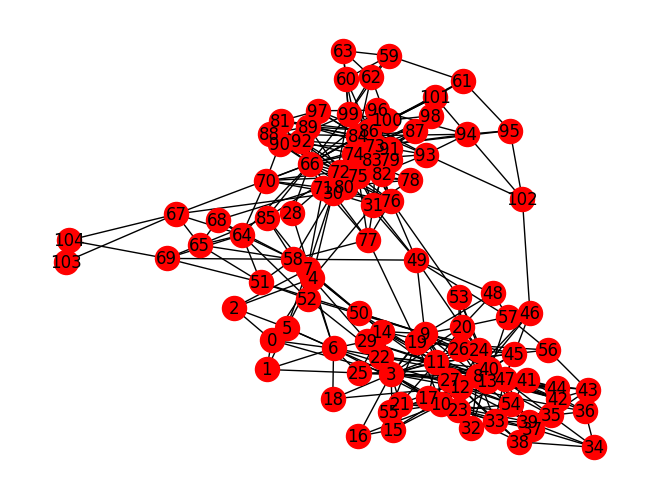

Generation  10 , NMI:  0.9701259431649127 , Modularity:  0.23808238336906948


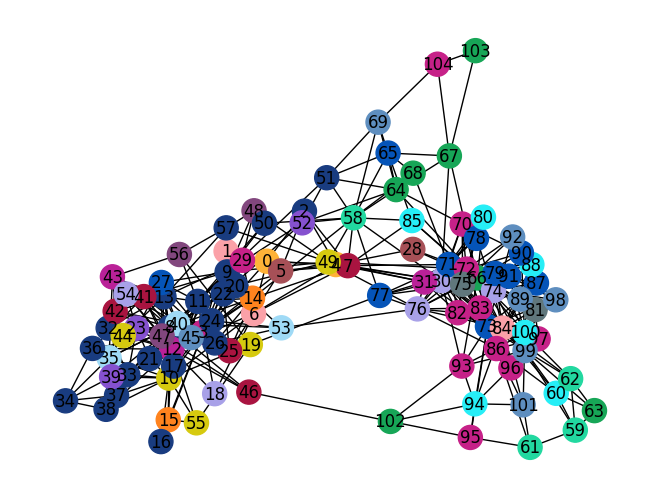

Generation  20 , NMI:  0.9941338483205132 , Modularity:  0.24628112771941732


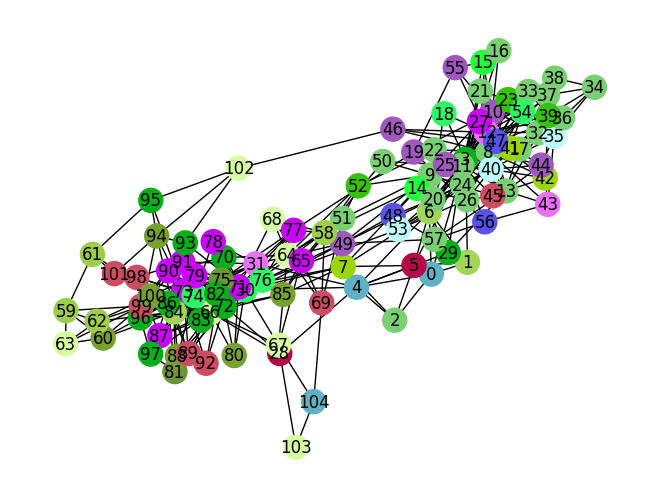

Generation  30 , NMI:  0.9932641721610698 , Modularity:  0.24628112771941732


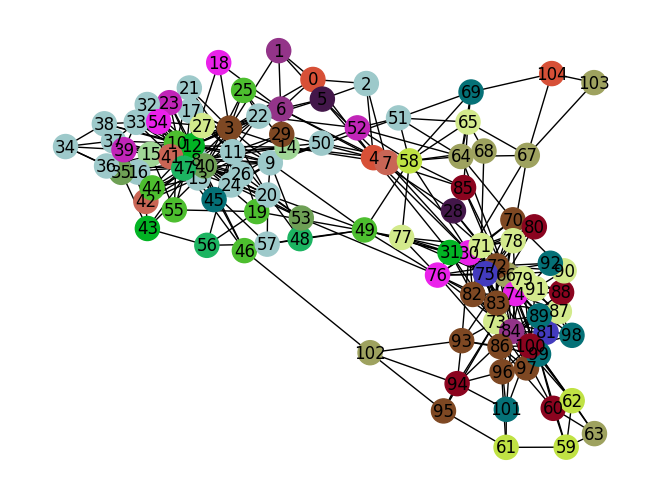

Generation  40 , NMI:  0.992077569889822 , Modularity:  0.23619273862228188


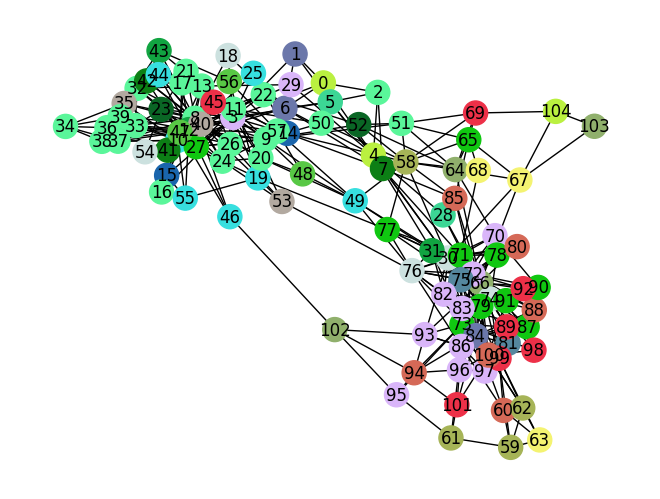

Generation  50 , NMI:  0.9857100560230503 , Modularity:  0.2495899342352209


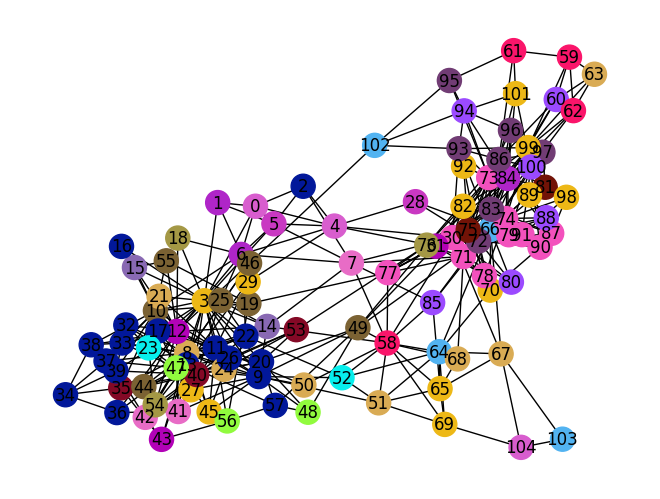

Generation  60 , NMI:  0.98666279322107 , Modularity:  0.24828132311125511


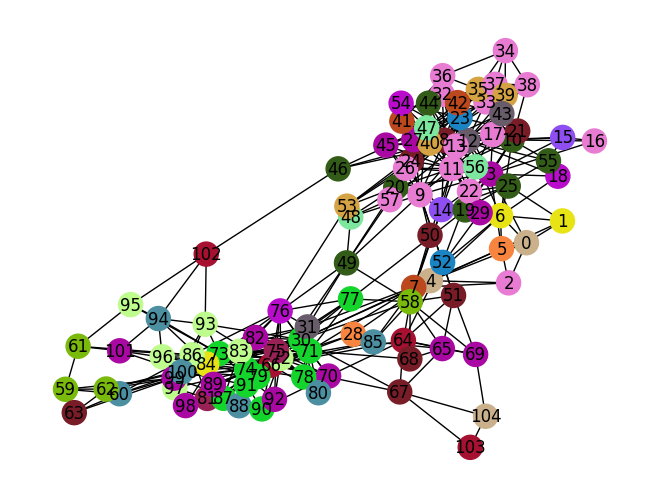

Generation  70 , NMI:  0.9926417375271757 , Modularity:  0.2516723998745379


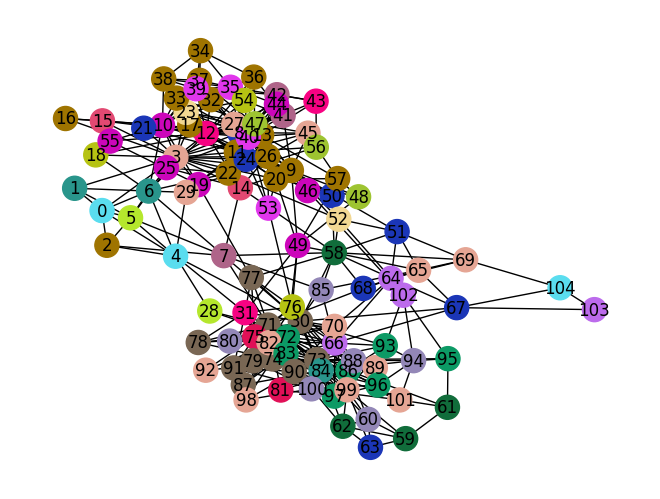

Generation  80 , NMI:  0.9970419514275792 , Modularity:  0.2516723998745379


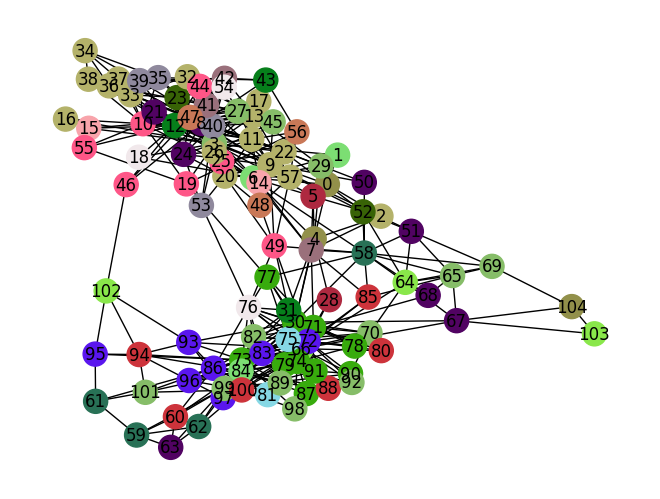

Generation  90 , NMI:  0.9997827940810932 , Modularity:  0.2516723998745379


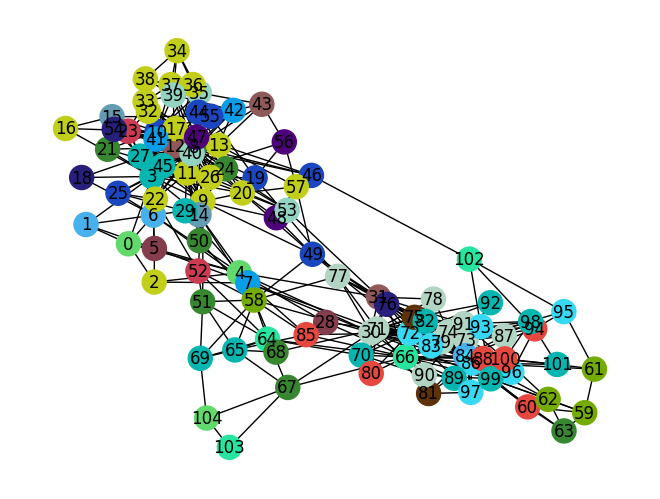

Generation  100 , NMI:  1.0 , Modularity:  0.2516723998745379


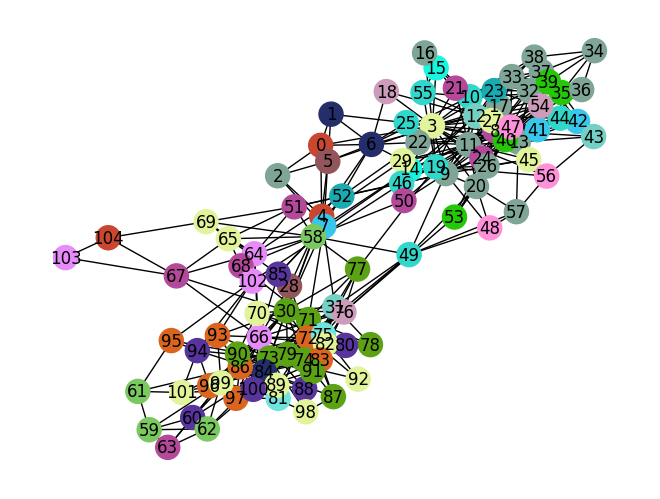

In [11]:
best_community, NMI, modularity = GWO(nodes,edges)